## Import Libraries

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.simplefilter("ignore")

In [4]:
df = pd.read_csv('datasets/final_dataset.csv')

In [5]:
df.head()

,date,temp,weather,wind,humidity,day_power
0,2012-01-01,12.333333,Cloudy,21.333333,89.333333,0.8
1,2012-01-02,7.787234,Scattered clouds,17.212766,81.425532,2.9
2,2012-01-03,8.208333,Fog,32.354167,78.229167,0.8
3,2012-01-04,7.354167,Scattered clouds,26.375000,71.041667,2.7
4,2012-01-05,8.292683,Scattered clouds,39.170732,77.804878,1.6


In [6]:
df.date = pd.to_datetime(df.date)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2691 entries, 0 to 2690
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       2691 non-null   datetime64[ns]
 1   temp       2686 non-null   float64       
 2   weather    2691 non-null   object        
 3   wind       2679 non-null   float64       
 4   humidity   2668 non-null   float64       
 5   day_power  2691 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 126.3+ KB


In [8]:
df['weather'].value_counts()

Passing clouds      974
Scattered clouds    903
Partly sunny        425
Sunny               258
Fog                 114
Cloudy               17
Name: weather, dtype: int64

In [9]:
df.set_index('date',inplace=True)

In [10]:
df.head()

,temp,weather,wind,humidity,day_power
date,,,,,
2012-01-01,12.333333,Cloudy,21.333333,89.333333,0.8
2012-01-02,7.787234,Scattered clouds,17.212766,81.425532,2.9
2012-01-03,8.208333,Fog,32.354167,78.229167,0.8
2012-01-04,7.354167,Scattered clouds,26.375000,71.041667,2.7
2012-01-05,8.292683,Scattered clouds,39.170732,77.804878,1.6


## Spliting data

In [11]:
train = df[:'31-12-2018']
test = df['01-01-2019':]

In [12]:
features = train.drop(['day_power'], axis=1) 
columns=features.columns 
labels = train['day_power'].copy() 
features.head() 

,temp,weather,wind,humidity
date,,,,
2012-01-01,12.333333,Cloudy,21.333333,89.333333
2012-01-02,7.787234,Scattered clouds,17.212766,81.425532
2012-01-03,8.208333,Fog,32.354167,78.229167
2012-01-04,7.354167,Scattered clouds,26.375000,71.041667
2012-01-05,8.292683,Scattered clouds,39.170732,77.804878


In [13]:
num_attr = list(features.drop(['weather'],axis=1)) 
cat_attr = ['weather'] 

## Making a Pipeline to apply all transformation to the dataset

In [14]:
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import MinMaxScaler 


num_pipeline = Pipeline([ 
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', MinMaxScaler()) 
]) 

cat_pipeline = Pipeline([ 
    ('encoder', OneHotEncoder()) 
]) 

full_pipeline = ColumnTransformer([ 
    ('num_pipeline', num_pipeline, num_attr),
    ('cat_pipeline', cat_pipeline, cat_attr) 
]) 

In [15]:
prepared_features = full_pipeline.fit_transform(features) 

## Model

In [16]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error as mse 
from sklearn.model_selection import cross_val_score  

lin_reg = LinearRegression() 
lin_reg.fit(prepared_features, labels) 
y_predicted = lin_reg.predict(prepared_features) 
scores = cross_val_score(lin_reg, prepared_features, labels, 
                         scoring='neg_mean_squared_error', cv=10) 
scores=np.sqrt(-scores) 
display(scores.mean()) 
scores.std() 

4.483712914185638

0.62437041334718

## Applying Pipeline to test data

In [17]:
test_features = test.drop(['day_power'], axis=1) 
test_labels = test['day_power'].copy() 

In [18]:
prepared_test = full_pipeline.transform(test_features) 
test_predicted = lin_reg.predict(prepared_test)

In [19]:
scores = cross_val_score(lin_reg, prepared_test, test_labels, 
                         scoring='neg_mean_squared_error', cv=10) 
scores=np.sqrt(-scores) 
display(scores.mean()) 
scores.std() 

5.017880921632056

0.9910831236866414

## Plotting Predictions

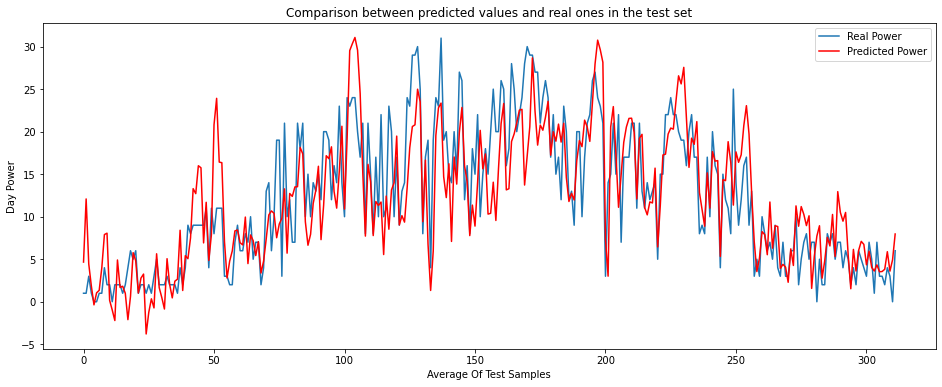

In [20]:
plt.figure(figsize=(16,6))
plt.plot(range(len(test_labels)), test_labels)
plt.plot(range(len(test_predicted)), test_predicted, 'r')
plt.title('Comparison between predicted values and real ones in the test set')
plt.ylabel('Day Power')
plt.xlabel('Average Of Test Samples')
plt.legend(['Real Power', 'Predicted Power'])
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_absolute_error(test_labels,test_predicted)

3.653024043038139

In [22]:
mean_squared_error(test_labels,test_predicted)

23.449539585085315

## Saving two files of Preprocessing and model

In [23]:
import pickle
pickle.dump(full_pipeline, open('Models/preprocessing.pkl', 'wb'))

In [24]:
pickle.dump(lin_reg, open('Models/model.pkl', 'wb'))

In [25]:
test_features.head()

,temp,weather,wind,humidity
date,,,,
2019-01-01,7.750000,Scattered clouds,17.958333,83.229167
2019-01-02,6.022222,Passing clouds,13.244444,69.222222
2019-01-03,5.125000,Partly sunny,8.458333,82.104167
2019-01-04,4.729167,Partly sunny,11.687500,85.312500
2019-01-05,6.425532,Scattered clouds,16.680851,93.297872


## Loading two models

In [26]:
preprocessing_pipeline = pickle.load(open('Models/preprocessing.pkl', 'rb'))

In [27]:
pickled_model = pickle.load(open('Models/model.pkl', 'rb'))

In [28]:
prepared_api = preprocessing_pipeline.transform(test_features)

In [29]:
predicted_pickle = pickled_model.predict(prepared_api)

In [30]:
prepared_api[0]

array([0.48056619, 0.40946642, 0.75422265, 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        ])